In [5]:
import Pkg
Pkg.activate("../../Tasks2D")

import LineWorlds
const L = LineWorlds
const G = L.Geometry

using Plots

using VoxelRayTracers # For lineworld -> gridworld
using AStarSearch     # For gridworld path planning

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


In [76]:
function line_to_grid(_segs, _bb, ϵ)
    (x1, y1), (x2, y2) = _bb
    edges = ((x1 - ϵ):ϵ:(x2 + ϵ), (y1 - ϵ):ϵ:(y2 + ϵ))

    grid = [false for _ in edges[1], _ in edges[2]]
    for seg in _segs
        if G.diff(seg) ≈ [0, 0]
            continue
        end
        ray = (position=seg.x, velocity=G.diff(seg))
        for hit in eachtraversal(ray, edges)
                                    # TODO: is this a hack or no?
            if hit.exit_time ≤ 1. #|| (hit.entry_time == 1.0 && (ray.velocity[1] > 0 || ray.velocity[2] > 0))
                grid[hit.voxelindex] = true
            end
        end
    end

    linecoords_to_gridcoords(x, y) = (
        Int(round((x - edges[1][1] + ϵ) / ϵ)),
        Int(round((y - edges[2][1] + ϵ) / ϵ))
    )
    gridcoords_to_linecoords(x, y) = (
        edges[1][x],
        edges[2][y]
    )

    return grid, edges, linecoords_to_gridcoords, gridcoords_to_linecoords
end

line_to_grid (generic function with 1 method)

In [75]:
size(grid)

(57, 123)

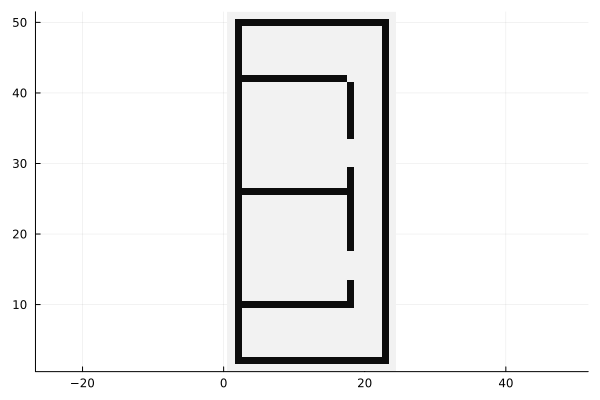

In [128]:
### Load environment as gridworld. ###

(_segs, _bb, _center) = L.load_env_sparse("/Users/georgematheos/Developer/research/summer2023/tasks2d/data/environments/ambig.json")

ϵ = 0.25
(grid, edges, l_to_g, g_to_l) = line_to_grid(_segs, _bb, ϵ)

heatmap(transpose(map(x -> x ? 0 : 1, grid)), aspect_ratio=:equal, color=:grays, cbar=false)

In [129]:
import GridWorlds
const GW = GridWorlds

GridWorlds

In [130]:
w = GridWorlds.boolmatrix_to_grid(grid, (length(edges[1]), length(edges[2])))

GridWorlds.FGridWorld(FunctionalCollections.PersistentVector{GridWorlds.GridCell}[[GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty  …  GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty], [GridWorlds.empty, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall  …  GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.empty], [GridWorlds.empty, GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall  …  GridWorlds.wall, GridWor

In [131]:
cartesian_dist((x, y), (x2, y2)) = sqrt((x - x2)^2 + (y - y2)^2)
taxi_dist((x, y), (x2, y2)) = abs(x - x2) + abs(y - y2)

taxi_dist (generic function with 1 method)

In [132]:
initialpos = l_to_g(1., 5.)
goalpos    = l_to_g(1., 11.)

results = astar(
    # state to neighbors
    pos -> unique(
        GW.newpos(w, pos, dir)
        for dir in (:up, :down, :left, :right, :stay)
    ),
    initialpos, # Initial world state
    goalpos; # Goal world state
    heuristic = (
        (pos, goal) -> taxi_dist(pos, goal)
    ),
    isgoal = ((pos, goal) -> pos == goal),
    timeout = 10.
)

# results = astar(
#     # state to neighbors
#     _w -> Set([
#         # try
#             GW.move_agent(_w, dir)
#         # catch e
#         #     println("agent pos: ", GW.agentpos(_w))
#         #     println("dir: ", dir)
#         #     error(e)
#         # end
#         for dir in (:up, :down, :left, :right, :stay)
#     ]),
#     GW.place_agent(w, initialpos), # Initial world state
#     GW.place_agent(w, goalpos); # Goal world state
#     heuristic = (
#         (w, goal) -> taxi_dist(GW.agentpos(w), GW.agentpos(goal))
#     ),
#     isgoal = ((w, goal) -> GW.agentpos(w) == GW.agentpos(goal)),
#     timeout = 10.
# )

AStarSearch.AStarResult{Tuple{Int64, Int64}, Int64}(:success, [(6, 22), (7, 22), (8, 22), (9, 22), (9, 21), (10, 21), (11, 21), (12, 21), (13, 21), (14, 21)  …  (15, 46), (14, 46), (13, 46), (12, 46), (11, 46), (10, 46), (9, 46), (8, 46), (7, 46), (6, 46)], 60, 395, 96)

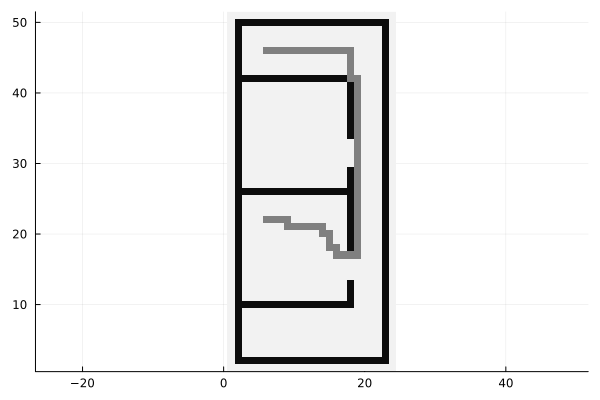

In [133]:
results_grid = [false for _ in edges[1], _ in edges[2]]
for pos in results.path
    results_grid[pos...] = true
end

heatmap(transpose([
    w ? 0 : r ? 0.5 : 1
    for (w, r) in zip(grid, results_grid)
]), aspect_ratio=:equal, color=:grays, cbar=false)


In [175]:
# Find the action which moves us distance 1.0 which most closely matches the path.
function apply_action_coarse(pos, dir, coarse_dist=1.0)
    n_steps = Int(coarse_dist/ϵ)
    for i in 1:n_steps
        pos = GW.newpos(w, pos, dir)
    end
    return pos
end
function find_coarse_action(pos, path)
    # compute the distance to the best point in the path for each coarse action
    best_dist = Inf
    best_action = nothing
    resulting_pos = nothing
    for dir in (:up, :down, :left, :right, :stay)
        new_pos = apply_action_coarse(pos, dir)
        for (i, p) in enumerate(path)
            # Cost = Distance to point p on path
            #      - distance of p from the point on the path from directly taking action
            dist = cartesian_dist(new_pos, p) - abs(i * ϵ + 1)
            if dist < best_dist
                best_dist = dist
                best_action = dir
                resulting_pos = new_pos
            end
        end
    end

    return (best_action, resulting_pos)
end

find_coarse_action (generic function with 1 method)

In [179]:
function generate_coarse_path(pos, path)
    coarse_path = [pos]
    # while taxi_dist(pos, path[end]) > 10
    for _=1:20
        (action, pos) = find_coarse_action(pos, path)
        push!(coarse_path, pos)
    end
    # end
    return coarse_path
end

generate_coarse_path (generic function with 1 method)

In [180]:
cpath = generate_coarse_path(initialpos, results.path)


MethodError: MethodError: Cannot `convert` an object of type Nothing to an object of type Tuple{Int64, Int64}

Closest candidates are:
  convert(::Type{Tuple{T, T}}, !Matched::CUDA.WMMA.LLVMStruct2{T}) where T
   @ CUDA ~/.julia/packages/CUDA/pCcGc/src/device/intrinsics/wmma.jl:140
  convert(::Type{T}, !Matched::CartesianIndex) where T<:Tuple
   @ Base multidimensional.jl:128
  convert(::Type{T}, !Matched::T) where T<:Tuple
   @ Base essentials.jl:411
  ...


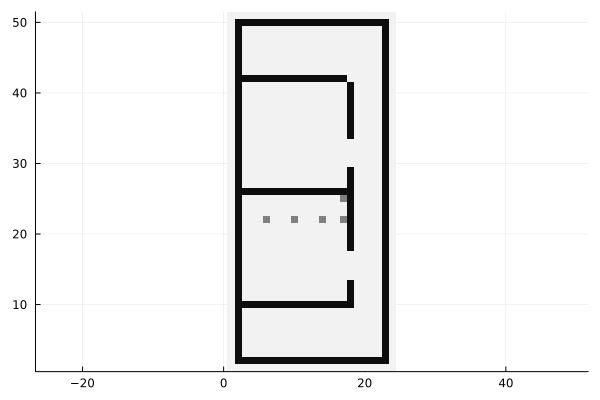

In [178]:
results_grid = [false for _ in edges[1], _ in edges[2]]
for pos in cpath
    results_grid[pos...] = true
end

heatmap(transpose([
    w ? 0 : r ? 0.5 : 1
    for (w, r) in zip(grid, results_grid)
]), aspect_ratio=:equal, color=:grays, cbar=false)


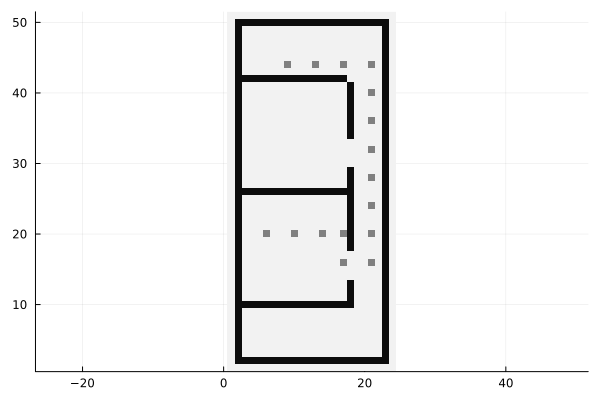

In [187]:
### Plan using coarse actions ###
initialpos = l_to_g(1., 4.5)
goalpos    = l_to_g(1.5, 11.)

results_coarse = astar(
    # state to neighbors
    pos -> unique(
        apply_action_coarse(pos, dir)
        for dir in (:up, :down, :left, :right, :stay)
    ),
    initialpos, # Initial world state
    goalpos; # Goal world state
    heuristic = (
        (pos, goal) -> taxi_dist(pos, goal)
    ),
    isgoal = ((pos, goal) -> taxi_dist(pos, goal) < 4),
    timeout = 10.
)

results_grid = [false for _ in edges[1], _ in edges[2]]
for pos in results_coarse.path
    results_grid[pos...] = true
end

heatmap(transpose([
    w ? 0 : r ? 0.5 : 1
    for (w, r) in zip(grid, results_grid)
]), aspect_ratio=:equal, color=:grays, cbar=false)
